# DSFB Assignment 3

### IMPORTS

In [65]:
# Standard imports
import numpy  as np
import pandas as pd

import itertools
import random
import math  

# Plotting
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
%matplotlib inline  
import seaborn as sns

# Package to generate dummy data
from faker import Faker

# ignore some warnings 
import warnings
warnings.filterwarnings('ignore')

# Utils for covariance/correlation matrix
from statsmodels.stats.moment_helpers import cov2corr, corr2cov

# Use a specific plotting style
plt.rcParams['figure.figsize'] = [12, 8]
plt.style.use('ggplot')

In [334]:
# Set a seed for replication
SEED = 1  # Use this anywhere a stochastic function allows you to set a seed

# PREP:  Generate a dataset for analysis.  

**NOTE** - There are no "problems" to complete in tbhis part, but it is helpful background for the next section on fraud analysis.

In this section we generate simple example to understand how to **detect and predict cases of fraud**. Fraud identification and prediction are difficult tasks and require both subject matter expertise as well as analytical skills. In order to illustrate it and have a good understanding of the techniques being used later on, we use a **simulated dataset**. This simulated dataset will be used later in the assignment. Of course, many real use cases involving fraud analytics are far from any simulated examples; however these examples will help in getting a good understanding of the strong and weak points related to a specific technique. Although being a simulated example, we will make it a realistic one and won't make fraud detection and prediction such an easy task!

### Salary dataset

Imagine that you are working in a tax department and collect information about tax declarations of citizens from a specific municipality. Typically, the data you collect is provided by the citizens themselves and relies on their honest feedback.


Let's first create this dummy dataset. The dataset contains 100 citizens with the following attributes:

- Name of the citizen
- Salaries of citizen (in USD) within a range of 1000 to 3000 (Monthly)
- Age of the citizen
- Number of siblings



#### Generating names

In order to make this dataset more appealing and be able to identify fraudsters, let's add random names to these individuals. For generating the names (and make them look like real ones) we use a Python library called *Faker*. 


In [335]:
# To ensure the results are reproducible
np.random.seed(123)

In [336]:
# Set Number of citizens
nb_citizens = 100

In [337]:
# Instantiate Faker
fake = Faker()

# To ensure the results are reproducible
Faker.seed(123)

names_list = []
fake = Faker()
for _ in range(nb_citizens):
  names_list.append(fake.name())

#### Generating salary and age

We generate both salary and age attributes with a given degree of relationship between them. The generation of these two columns comes from a multivariate normal distribution (with given correlation matrix).

In [338]:
# Set print options for scientific notation
np.set_printoptions(suppress=True)

# Specifying a given correlation matrix
corr = np.array([[1., 0.75], [0.75, 1.]])
print('Correlation matrix of simulated data: \n',corr, '\n')

# Standard deviations/means of Salary and age
stdev = np.array([400, 8])
mean = np.array([2500, 42])

# Resulting covariance matrix
cov = corr2cov(corr, stdev)
print('Covariance matrix of simulated data: \n',cov)

Correlation matrix of simulated data: 
 [[1.   0.75]
 [0.75 1.  ]] 

Covariance matrix of simulated data: 
 [[160000.   2400.]
 [  2400.     64.]]


In [339]:
# Generate data from multivariate normal distribution
data_simulated = np.random.multivariate_normal(mean=mean, cov=cov, size=nb_citizens)

# Check the first 10 records
data_simulated[:10].round(0)

array([[2934.,   54.],
       [2387.,   32.],
       [2731.,   54.],
       [3471.,   54.],
       [1994.,   30.],
       [2772.,   46.],
       [1903.,   30.],
       [2678.,   42.],
       [1617.,   40.],
       [2098.,   38.]])

In [340]:
# Transforming to dataframe
data_salary = pd.DataFrame(data_simulated.round(0))

# adding column name to the respective columns 
data_salary.columns = ['salary', 'age']

# Check the header
data_salary.head()

salary   age
0  2934.0  54.0
1  2387.0  32.0
2  2731.0  54.0
3  3471.0  54.0
4  1994.0  30.0

#### Generating number of siblings

Randomly generating the number of siblings of citizens. The random generation is done independently of the previous data generating process (DGP).

In [341]:
# Simulating a Poisson distribution
nb_siblings = np.random.poisson(1.5, nb_citizens)

#### Bringing it all together

Finally, we add all simulated data together and check the header of the dataframe. 

In [342]:
# Adding the index name
data_salary.index = names_list

# Adding number of siblings to the dataset
data_salary['nb_siblings'] = nb_siblings

data_salary.head()

salary   age  nb_siblings
Brandon Russell   2934.0  54.0            1
Steven Johnson    2387.0  32.0            1
Evelyn Christian  2731.0  54.0            2
George Cook       3471.0  54.0            1
Aaron Graham      1994.0  30.0            2

In [343]:
# Check the data types
data_salary.dtypes

salary         float64
age            float64
nb_siblings      int64
dtype: object

In [344]:
# Describing the generated dataset
data_salary.describe()

salary         age  nb_siblings
count   100.000000  100.000000   100.000000
mean   2447.640000   40.540000     1.420000
std     394.444156    7.947327     1.147505
min    1543.000000   20.000000     0.000000
25%    2167.250000   35.750000     1.000000
50%    2449.000000   40.500000     1.000000
75%    2722.750000   47.000000     2.000000
max    3471.000000   60.000000     5.000000

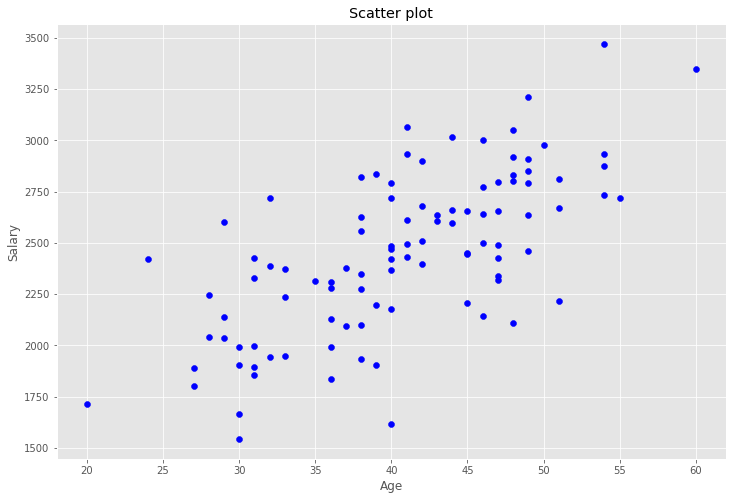

In [345]:
# Showing scatter plot between salary and age
plt.scatter(data_salary['age'], data_salary['salary'], color='blue')
plt.title('Scatter plot')
plt.xlabel('Age')
plt.ylabel('Salary')
plt.show()

### Polluting the Salary dataset with amomalous cases

The current dataset is very regular and does not have any unusual cases which might represent fraud. So let's pollute it with some anomalies. We will add anomalies to the dataset (clear as well as unclear anomalies). By doing so, we will be able to see to what extent we are able to identify anomalies and disentangle "normal" observations from anomalous ones in the dataset.

In [346]:
# Defining a certain proportion of contamination
contamination_rate = round(0.1 * nb_citizens, 0)
print(contamination_rate)

10.0


In [347]:
# Specifying a given correlation matrix for the contamination
corr_conta = np.array([[1., -0.2], [-0.2, 1.]])

# Standard deviations/means of Salary and age
stdev_conta = np.array([170, 10])
mean_conta = np.array([3200, 33])

# Resulting covariance matrix
cov_conta = corr2cov(corr_conta, stdev_conta)
# Generate contaminated data
data_conta = np.random.multivariate_normal(mean=mean_conta, cov=cov_conta, size=int(contamination_rate))

In [348]:
data_conta = pd.DataFrame(data_conta.round(0))
data_conta.head()

# adding column name to the respective columns 
data_conta.columns = ['salary', 'age']

data_conta['nb_siblings'] = np.random.poisson(1, int(contamination_rate))

In [349]:
names_fake_list = []
fake = Faker()
for _ in range(int(contamination_rate)):
  names_fake_list.append(fake.name())

# Adding the index name
data_conta.index = names_fake_list

data_conta.head()

salary   age  nb_siblings
Christy Johnson    3259.0  33.0            1
Christian Walker   3331.0  39.0            2
Matthew Hamilton   3157.0  27.0            0
Jeanette Terrell   3049.0  46.0            3
Andrew Taylor DDS  3217.0  31.0            1

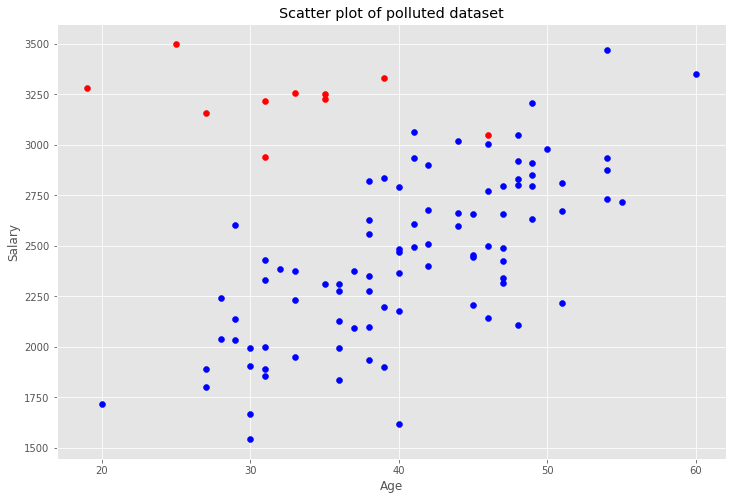

In [350]:
# Plotting the scatter plots
plt.scatter(data_salary[:90]['age'], data_salary[:90]['salary'], color = 'blue')
plt.scatter(data_conta['age'], data_conta['salary'], color = 'red')
plt.title('Scatter plot of polluted dataset')
plt.xlabel('Age')
plt.ylabel('Salary')
plt.show()

We now combine the two datasets in order to create the final one. **In the sequel, when using unsupervised methods, we will do as if we did not know about those artificially generated "anomalies"**. As you can see from the scatterplot, it is not that obvious to detect which points are true anomalies. This is where you understand the part of subjectivity related to the concept of anomaly. Also, remember that fraudsters ("red points on the map") will do everything not to be detected, *i.e.* to look as much as possible as the "blue  points".

In [351]:
# Combine the DataFrames (one on top of the other) 
data_final = pd.concat([data_salary[:90], data_conta], axis=0)
data_final.head()

# Add a class attribute for fraud
data_final['fraud'] = np.append(np.repeat(0,90), np.repeat(1, 10))

# Check the data shape
data_final.shape

(100, 4)

In [352]:
# Save dataset as csv
data_final.to_csv("data/data_simulated_fraud.csv", index = True)

# PART 2:  Fraud Analysis  

Typically you have only one section at the top of the notebook with all the setup and meta data. But as this is an assignment that spans different types of data and problems, we will simply as if ":from the top." We do that with the notebook magic command `%reset -f`

In [353]:
%reset -f

### Setup

In [354]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = [12, 8]

# Package to generate dummy data
from faker import Faker

# Import most important modules from the sklearn library
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans, DBSCAN
from sklearn.covariance import EmpiricalCovariance, MinCovDet
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight

# Class imbalance
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from collections import Counter

# Use a specific plotting style
plt.style.use('ggplot')

**PROBLEM**: read back in the data generated above in the prepatory step (saved as `data_simulated_fraud.csv`).

In [355]:
# Read data generated above and look at the head

data=pd.read_csv('data/data_simulated_fraud.csv',index_col=[0])

data.head()

salary   age  nb_siblings  fraud
Brandon Russell   2934.0  54.0            1      0
Steven Johnson    2387.0  32.0            1      0
Evelyn Christian  2731.0  54.0            2      0
George Cook       3471.0  54.0            1      0
Aaron Graham      1994.0  30.0            2      0

In [356]:
# We will use the following function to print out key metrics from confusion matrix
def PrintMetrics(cmat, y_test, pred):
   # separate out the confusion matrix components
   tpos = cmat[0][0]
   fneg = cmat[1][1]
   fpos = cmat[0][1]
   tneg = cmat[1][0]
   # calculate F1 score, Recall scores, precision scores
   f1Score = round(f1_score(y_test, pred), 2)
   recallScore = round(recall_score(y_test, pred), 2)
   precisionScore = round(precision_score(y_test, pred), 2)
   # calculate and display metrics
   print(cmat)
   print( 'Accuracy: '+ str(np.round(100*float(tpos+fneg)/float(tpos+fneg + fpos + tneg),2))+'%')
   print("Sensitivity/Recall: {recall_score}".format(recall_score = recallScore))
   print("Precision: {precision_score}".format(precision_score = precisionScore))
   print("F1 Score: {f1_score}".format(f1_score = f1Score))

## Supervised methods


If you are lucky to have **labelled data**, *i.e.* you know clear cases of fraud, then you can use supervised machine learning techniques. The primary purpose is to create a model to be able to **disentangle non-fraudulous cases from fraudulous ones**. Once you have a good performing model, you are able to predict cases of fraud.

So let's try to use supervised machine learning methods in order to see how well we can discriminate between the two sets of points. In this case, we are dealing with a **binary classification problem**.

### Target distribution

**PROBLEM**: Check the distribution of the target variable to have an idea of the imbalance in the dataset

In [357]:
# Print out distribution of target variable

data.groupby(data.fraud).count()

salary  age  nb_siblings
fraud                          
0          90   90           90
1          10   10           10

**PROBLEM**: Plot a BarPlot for the target variable.

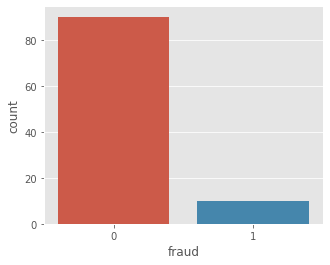

In [358]:
plt.rcParams['figure.figsize'] = [5, 4]
sns.countplot(x="fraud",data=data)

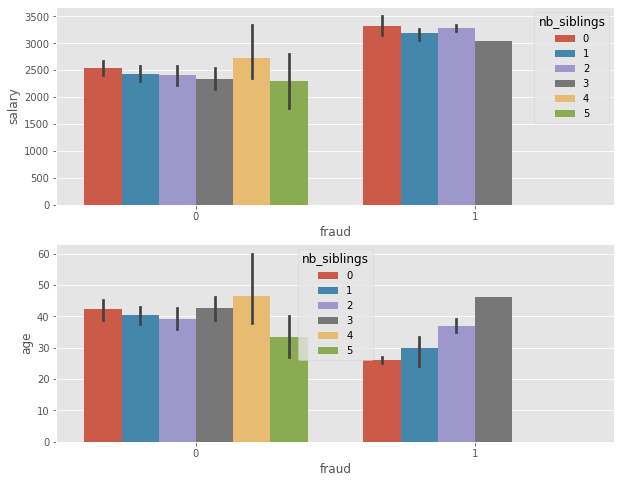

In [359]:
# Check barplot wirh other features
plt.rcParams['figure.figsize'] = [10, 8]
fig, axes = plt.subplots(2)
sns.barplot(ax=axes[0],x="fraud", y="salary", hue="nb_siblings", data=data)
sns.barplot(ax=axes[1],x="fraud", y="age", hue="nb_siblings", data=data)

## Traditional classifiers

Let's start with the traditional stack of **binary classification techniques**. Remember the classification techniques you have seen in the DSFM workshop.
The focus of the following sections is *not necessarily to find the set of optimal parameters*, *i.e.* hyperparameter tuning, but rather to show how different techniques may be used.


In [409]:
# Split apart features from the target variable
y = data['fraud'].values
X = data[['salary', 'age', 'nb_siblings']]

### Data splitting

#### Typical splitting

Remember that the first step in supervised learning is to split the original dataset into **train/test datasets** (eventually validation set). Typically, the ratio considered is 80/20 for the train/test split. 


In [361]:
# Split data in training and test, the classic way we have done it before, by using the train_test_split() function
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

**PROBLEM**: Print the count and percentage of fraud for the training set.

In [362]:
# Print distribution of target variable for training

print(pd.Series(Y_train).value_counts())
pd.Series(Y_train).value_counts()/len(Y_train)

0    72
1     8
dtype: int64


0    0.9
1    0.1
dtype: float64

**PROBLEM**: Print the count and percentage of fraud for the testing set.

In [363]:
# Print distribution of target variable for training


print(pd.Series(Y_test).value_counts())
pd.Series(Y_test).value_counts()/len(Y_test)


0    18
1     2
dtype: int64


0    0.9
1    0.1
dtype: float64

**PROBLEM**: In the case of highly imbalanced dataset, what could eventually go wrong with this splitting approach?

ANSWER:  
`The model minimizes number of erors, price of error is the same, the model will learn to predict only the most frequent class 



#### Stratified splitting

Given the strong target imbalance, it is important to make sure that the target distributions are similar in both the training and test datasets. To do so, one can use **stratified sampling** on the target variable. Look in the documentation to figure out how to make the train_test_split() function pull stratefied samples.

**PROBLEM**: Use the train_test_split() function pull stratefied samples.

In [364]:
# Split data into training and test set, using stratification
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state=42)

**PROBLEM**: Print the count and percentage of fraud for the stratefied training set.

In [365]:
# Print distribution of target variable for training


print(pd.Series(Y_train).value_counts())
pd.Series(Y_train).value_counts()/len(Y_train)


0    72
1     8
dtype: int64


0    0.9
1    0.1
dtype: float64

**PROBLEM**: Print the count and percentage of fraud for the stratefied testing set.

In [366]:
# Print distribution of target variable for training

print(pd.Series(Y_test).value_counts())
pd.Series(Y_test).value_counts()/len(Y_test)


0    18
1     2
dtype: int64


0    0.9
1    0.1
dtype: float64

## Dealing with class imbalance by using SMOTE

A main difficulty in fraud analytics is to deal with **class imbalance**, *i.e.* recall that you should have very few cases of fraud in comparison to cases of non-fraud. Different techniques to account for this imbalance in the dataset can be used. To help with this, we will use an over/under sampling called: **SMOTE** - the **Synthetic Minority Oversampling TEchnique (SMOTE)**. SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line. Specifically, a random example from the minority class is first chosen. Then k of the nearest neighbors for that example are found (typically k=5). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space.

In [367]:
# Instantiate SMOTE >>> You need to do this to get a smote object with which to work
smote = SMOTE()

Before you continue, you now need to spend some time to research how SMOTE works. This is self-directed learning, but in particular, figure out how to use the smote.fit_resample() function.

**PROBLEM**: Generate a NEW set of X and y data from the smote.fit_resample() function. Call your new variables `X_smote` and `y_smote`

In [368]:
# Generate a NEW set of X and y data from the smote.fit_resample() function.

X_smote,y_smote=smote.fit_resample(X,y)


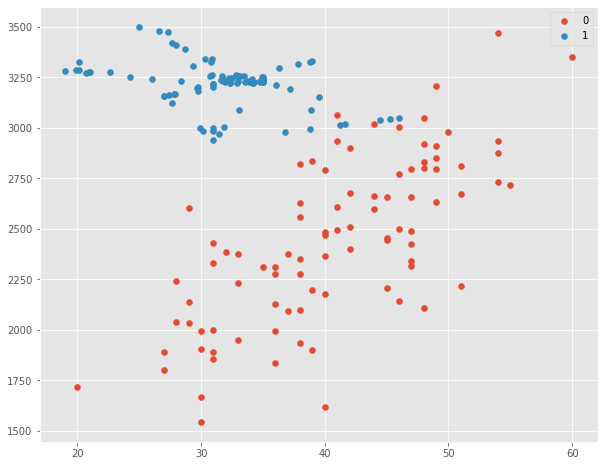

In [369]:
#illustrate new data
from numpy import where
from collections import Counter
from matplotlib import pyplot
# summarize class distribution
counter = Counter(y_smote)
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = where(y_smote == label)[0]
    pyplot.scatter( X_smote.loc[row_ix]['age'],X_smote.loc[row_ix]['salary'], label=str(label))
pyplot.legend()
pyplot.show()

In [370]:
counter

Counter({0: 90, 1: 90})

In [371]:
#get new data
data_new=pd.concat([X_smote,pd.Series(y_smote)],axis=1)

**PROBLEM**: Summarize the new class distribution generated by SMOTE.

In [372]:
# summarize the new class distribution



print(pd.Series(y_smote).value_counts())
pd.Series(y_smote).value_counts()/len(y_smote)

1    90
0    90
dtype: int64


1    0.5
0    0.5
dtype: float64

In [373]:
#rename a columnaof a new data
data_new.rename(columns={0:'fraud'},inplace=True)

**PROBLEM**: What do you now observe about the balance between cases of Fraud and cases of non-Fraud?

ANSWER: Target is balanced



**PROBLEM, PROBLEM, PROBLEM, PROBLEM, PROBLEM, PROBLEM, PROBLEM**: Perform an analysis of your choosing to compare the performance some classifer (again, of your choosing) method on the imbalanced, and the SMOTE-balanced, datasets.

_NOTE: This problem is long and involved, so it is worth the relative points of **SEVEN SEPARATE "PROBLEMS."**_ So try to make a comprehensive analysis. For example, you may want to contrast and compare between different classifiers, as well as between the different datasets. Be creative!

# Linear Regression

In [389]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix

In [390]:
#I will use repeated stratified k-fold cross-validation to evaluate the model. 
#and 3 repeats of 10-fold cross-validation,
#meaning that 10-fold cross-validation is applied three times fitting and evaluating 30 models on the dataset.

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
lr_scores = cross_val_score(LinearRegression(), X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
np.mean(lr_scores)

0.9851851851851852

In [391]:
# evaluate 
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
lr_scores_s = cross_val_score(LinearRegression(), X_smote, y_smote, scoring='roc_auc', cv=cv, n_jobs=-1)
np.mean(lr_scores_s)

0.9967078189300411

In [392]:
#My results may vary given the stochastic nature of the algorithm or evaluation procedure, 
#or differences in numerical precision. 
#Running cross_val a few times and comparing the average outcome 
# we get that Linear Regression works better for SMOTE (balanced dataset)

# Logistic Regression

In [393]:
from sklearn.linear_model import LogisticRegression

In [394]:

# evaluate 
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
logit_scores = cross_val_score(LogisticRegression(), X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
np.mean(logit_scores)


0.9925925925925926

In [395]:
# evaluate 
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
logit_scores_s = cross_val_score(LogisticRegression(), X_smote, y_smote, scoring='roc_auc', cv=cv, n_jobs=-1)
np.mean(logit_scores_s)

0.9962962962962963

In [ ]:
#Running cross_val a few times and comparing the average outcome 
# we get that Logistic Regression works better for SMOTE (balanced dataset)


# Logistic Regression with penalty l1 and StandardScaler

In [396]:
# Build pipeline   
from sklearn.pipeline import Pipeline
estimators = []
estimators.append(('standardize', StandardScaler()))         # tell it to standardize features
estimators.append(('logit_model_l1', LogisticRegression(solver='liblinear')))  # tell it to use a logit model
pipeline = Pipeline(estimators) 
pipeline.set_params(logit_model_l1__penalty='l1')            # tell it to regularize with L1 norm

Pipeline(steps=[('standardize', StandardScaler()),
                ('logit_model_l1',
                 LogisticRegression(penalty='l1', solver='liblinear'))])

In [397]:

# evaluate 
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
pipeline_scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
np.mean(pipeline_scores)

0.9925925925925926

In [398]:

# evaluate 
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
pipeline_scores_s = cross_val_score(pipeline, X_smote, y_smote, scoring='roc_auc', cv=cv, n_jobs=-1)
np.mean(pipeline_scores_s)

0.9967078189300411

In [ ]:
#Running cross_val a few times and comparing the average outcome 
# we get that Logistic Regression with penalty l1 works better for SMOTE (balanced dataset) and better that Logisticregression

# SVM

In [399]:
from sklearn import datasets, metrics, model_selection, svm

In [400]:
svm = svm.SVC(random_state=0)
# evaluate 
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
svm_scores = cross_val_score(svm, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
np.mean(svm_scores)

0.9703703703703703

In [401]:
# evaluate 
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
svm_scores_s = cross_val_score(svm, X_smote, y_smote, scoring='roc_auc', cv=cv, n_jobs=-1)
np.mean(svm_scores_s)

0.968724279835391

In [402]:
#Running cross_val a few times and comparing the average outcome 
# we get that SVM better for imbalanced dataset

# DecisionTree

In [403]:

# define model
DecisionTree = DecisionTreeClassifier()
# evaluate 
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
dt_scores = cross_val_score(DecisionTree, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
np.mean(dt_scores)

0.8240740740740741

In [404]:
# define model
DecisionTree = DecisionTreeClassifier()
# evaluate 
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
dt_scores_s = cross_val_score(DecisionTree, X_smote, y_smote, scoring='roc_auc', cv=cv, n_jobs=-1)
np.mean(dt_scores_s)

0.9703703703703702

In [ ]:
#Running cross_val a few times and comparing the average outcome 
# we get that DecisionTree works better for SMOTE (balanced dataset)

# Grid search k value for SMOTE oversampling for imbalanced classification

In [422]:
# grid search k value for SMOTE oversampling for imbalanced classification
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


# values to evaluate
k_values = [1, 2, 3, 4, 5, 6, 7]
for k in k_values:
    # define pipeline
    model = DecisionTreeClassifier()
    over = SMOTE(k_neighbors=k)
    steps = [('over', over), ('model', model)]
    pipeline = Pipeline(steps=steps)
    # evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X.reset_index().drop(columns=['index']), y, scoring='roc_auc', cv=cv, n_jobs=-1)
    score = mean(scores)
    print('> k=%d, Mean ROC AUC: %.3f' % (k, score))

> k=1, Mean ROC AUC: 0.887
> k=2, Mean ROC AUC: 0.883
> k=3, Mean ROC AUC: 0.885
> k=4, Mean ROC AUC: 0.891
> k=5, Mean ROC AUC: 0.885
> k=6, Mean ROC AUC: 0.887
> k=7, Mean ROC AUC: 0.885


# PART 3:  Time Series  

In this part of the Assignment, we work with the same methods of Time Series forecasting covered in class and lab, but now you will use the "Darts" library from Unit 8 (here in Lausanne) to help you! We'll use the airline data saved in the file `data/AirPassengers.csv`

In [16]:
%reset -f

In [115]:

!pip install u8darts



In [116]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import pandas as pd
import numpy as np
from datetime import datetime
import time
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    ExponentialSmoothing,
    ARIMA,
    StandardRegressionModel
)
from darts.metrics import mape, mase
from darts.utils.statistics import check_seasonality, plot_acf

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named 'darts'

In [6]:
from darts.models import NaiveSeasonal

ModuleNotFoundError: No module named 'darts'

In [7]:
import pandas as pd
from darts import TimeSeries

ModuleNotFoundError: No module named 'darts'

**PROBLEM**: Use the `Darts` package to plot the airline data in `data/AirPassengers.csv`

In [ ]:
# Plot the airline data



data=pd.read_csv('data/AirPassengers.csv')

ERROR! Session/line number was not unique in database. History logging moved to new session 260


In [ ]:
data.head()

ERROR! Session/line number was not unique in database. History logging moved to new session 261


**PROBLEM**: Create a training and validation series. Split the `TimeSeries` into a training and a validation series. The training series will be a `TimeSeries` object containing values until January 1958 (excluded), and the validation series a `TimeSeries` containing the rest.

In [ ]:
# Create a training and validation series





**PROBLEM**: Inspect seasonality in the datawith a plot from darts.

In [ ]:
# Inspect seasonality in the datawith a plot from darts





**PROBLEM**: Use darts to estimate an ARIMA model for this data.

In [ ]:
# Use darts to estimate an ARIMA model for this data




**PROBLEM**:Use the backtesting functionality of darts to test the performance we *would have obtained* if we *had been using this model* historically .

In [ ]:
# Inspect seasonality in the data with a plot from darts




**PROBLEM, PROBLEM, PROBLEM**: Use darts to ensemble together several different forecasting models. You may pick any two models you with.

_NOTE: This problem is long and involved, so it is worth the relative points of **THREE SEPARATE "PROBLEMS."**_

# PART 4: AGGLOMERATIVE CLUSTERING (without sklearn)

**NOTE: You may NOT use `sklearn` in this section...**

Suppose you have the following observations in a two-dimensional Euclidean space. Here we give you a dictionary with a label for the point, and the point in (x,y) coordinates. 

In [668]:
# Raw observations
data   = [(1,1), (2,1), (5,1), (7,1), (1,5), (3,4), (4,5) ]
labels = [ 'A',   'B',   'C',   'D',   'E',   'F',   'G']

# Clusters of 1 observation, at lowest level
a = [data[0], ]
b = [data[1], ]
c = [data[2], ]
d = [data[3], ]
e = [data[4], ]
f = [data[5], ]
g = [data[6], ]

You may use the following function to plot the data...

In [669]:
def plot_data(data, labels, xlim, ylim):
    """ Function to plot a list of (x,y) coordinates, with optional lables. 
        
        Args:  
              data     A list of (x,y) point to plot
              labels   A list of text labels, in same order as data.
    """
    
    fig, ax = plt.subplots()
    for point, label in zip(data, labels):
        ax.scatter(point[0], point[1], c='black')
        if labels: ax.annotate(label, point, textcoords="offset points", xytext=(1,10))
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.grid(True)
    return fig, ax

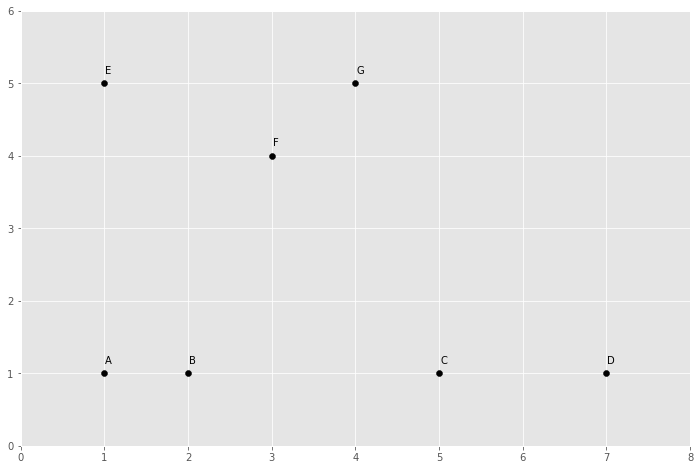

In [670]:
plot_data(data, labels, xlim=(0,8), ylim=(0,6))
pass

**PROBLEM**: Write a custom function in pure Python to calculate the Euclidean straight-line distance between any two points with (x,y) coordinates.

In [671]:
def distance(point_a, point_b):
    """ Function to calculate and return the Euclidean straight distance between any two points with (x,y) coordinates.
        
        Args:  
               point_a   (x,y) of point a
               point_b   (x,y) of point b
    """
    return ((point_a[0]-point_b[0])**2+(point_a[1]-point_b[1])**2)**(1/2)
    
    
    

In [672]:
distance(data[0],data[1])

1.0

**PROBLEM**: Write a custom function in pure Python to calculate a Euclidean distance matrix between a list of points; return a quasi-matrix as a pure Python "list of lists."

In [673]:
def distance_matrix(points):
    """ Function to calculate the point to point distances between a list of points.
        Return values in a quasi-"matrix" in the pure python form of a list-of-lists.
        
        Args:      
              points      A list of coordinates. For example: [(1,3), (4,9), (5,7)]
    """
    
    dis2=[]
    for point1 in points:
        dis=[]
        for point2 in points:
            dis.append(distance(point1, point2))
        dis2.append(dis)
            
    return dis2
    
    

In [674]:
#check 
distance_matrix(data)

[[0.0, 1.0, 4.0, 6.0, 4.0, 3.605551275463989, 5.0],
 [1.0, 0.0, 3.0, 5.0, 4.123105625617661, 3.1622776601683795, 4.47213595499958],
 [4.0, 3.0, 0.0, 2.0, 5.656854249492381, 3.605551275463989, 4.123105625617661],
 [6.0, 5.0, 2.0, 0.0, 7.211102550927978, 5.0, 5.0],
 [4.0,
  4.123105625617661,
  5.656854249492381,
  7.211102550927978,
  0.0,
  2.23606797749979,
  3.0],
 [3.605551275463989,
  3.1622776601683795,
  3.605551275463989,
  5.0,
  2.23606797749979,
  0.0,
  1.4142135623730951],
 [5.0, 4.47213595499958, 4.123105625617661, 5.0, 3.0, 1.4142135623730951, 0.0]]

**PROBLEM**: Write a custom function in pure Python to calculate the centroid of a cluster of coordinates.

In [675]:
def centroid(points):
    """ Function to calculate and return the (x,y) coordinates for the centroid of a list of such (x,y) coordinates.
        Args:  
              points      A list of coordinates for the cluster. For example: [(1,3), (4,9), (5,7)]
    """
    import operator
    centr=(0,0)
    for point in points:
        centr=tuple(map(operator.add,centr,point))
    
    return tuple(np.array(centr)*1/len(points))
    
    

In [676]:
centroid(data)

(3.2857142857142856, 2.5714285714285716)

In [677]:
data

[(1, 1), (2, 1), (5, 1), (7, 1), (1, 5), (3, 4), (4, 5)]

In [678]:
#check
23/7,18/7

(3.2857142857142856, 2.5714285714285716)

**PROBLEM**: Write a custom function in pure Python to calculate the Euclidean distance between the closest points between two different clusters.

In [679]:
def separation(cluster_a, cluster_b):
    """ Function to calculate and return the Euclidean distance between the closest points between two different clusters.
        
        Args:  
              points      A list of coordinates for the cluster. For example: [(1,3), (4,9), (5,7)]
    """
    dist_min=distance(cluster_a[0],cluster_b[0])
    for point_a in cluster_a:
        for point_b in cluster_b:
            if distance(point_a,point_b)<dist_min:
                dist_min=distance(point_a,point_b)
    return dist_min

    

**PROBLEM**: Write a custom function in pure Python to calculate the distortion of a cluster. Define "distortion" as the sum of the squared distances of each point to the centroid of the cluster.

In [680]:
def distortion(points):
    """ Function to calculate and return the distortion of a cluster. 
        Distortion is defined as the sum of the squared distances of each point to the centroid of the cluster.
        
        Args:  
              points      A list of coordinates for the cluster. For example: [(1,3), (4,9), (5,7)]
    """
    s=0
    c=centroid(points)
    for point in points:
        s=s+(distance(c,point))**2
    return s
    

    

In [681]:
distortion(data)

53.142857142857146

**PROBLEM**:  Use the custom distance_matrix() function coded above to calculate the distance matrix between all observations. Try to print this out in a readable format (optional).

In [682]:
# Calc and print distance matrix between all observations
pd.DataFrame(distance_matrix(data))



0         1         2         3         4         5         6
0  0.000000  1.000000  4.000000  6.000000  4.000000  3.605551  5.000000
1  1.000000  0.000000  3.000000  5.000000  4.123106  3.162278  4.472136
2  4.000000  3.000000  0.000000  2.000000  5.656854  3.605551  4.123106
3  6.000000  5.000000  2.000000  0.000000  7.211103  5.000000  5.000000
4  4.000000  4.123106  5.656854  7.211103  0.000000  2.236068  3.000000
5  3.605551  3.162278  3.605551  5.000000  2.236068  0.000000  1.414214
6  5.000000  4.472136  4.123106  5.000000  3.000000  1.414214  0.000000

**PROBLEM**: We started with seven "clusters" with one observation in each cluster. Now use hierarchical agglomerative clustering to fuse the data together (going from the bottom up). Use the distance matrix above to help you perform this step. You may do it manually (by inspecting the matrix) or you may do it programmatically. Once you decide the proper order of fusing clusters, make variable assignments by updating the code below.

In [683]:
# Define the next 6 clusters by defining a variable that holds a list of all the points in that cluster
___ =  ___ + ___
___ =  ___ + ___
___ =  ___ + ___
___ =  ___ + ___
___ =  ___ + ___
___ =  ___ + ___

In [684]:
cl1=[data[0],data[1]] #1
cl2=[data[5],data[6]] #1.414214
cl3=[data[2],data[3]] #2
cl4=[data[4],data[5],data[6]] #2.236068 with  5th point

In [685]:
separation(cl1,cl2),separation(cl1,cl3),separation(cl1,cl4)

(3.1622776601683795, 3.0, 3.1622776601683795)

In [686]:
separation(cl2,cl3)

3.605551275463989

In [687]:
separation(cl3,cl4)

3.605551275463989

In [688]:
cl5=[data[0],data[1],data[2],data[3]] #clsuter1 and 3, dist= 3.0
cl6=data 

**PROBLEM**: Summarize the clustering process by printing out values for the items in the cluser, the separation distance between the old relevant clusters before fusing, the internal distortion within the new cluster after fusing, and the members of the new cluster after fusing.

In [690]:
# Print out the following values for each of the clusters with 2 or more observations in them
#print('CLUSTER'.center(20), 'DISTANCE'.center(10), 'DISTORTION'.center(20), 'MEMBERS')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

display(pd.DataFrame([['A,B',distance(data[0],data[1]),distortion(cl1),cl1],
['F,G',distance(data[5],data[6]),distortion(cl2),cl2],
['C,D',distance(data[2],data[3]),distortion(cl3),cl3],
['E,F,G',distance(data[4],data[5]),distortion(cl4),cl4],
['A,B,C,D',separation(cl1,cl3),distortion(cl5),cl5],
['A,B,C,D,E,F,G',separation(cl4,cl5),distortion(cl6),cl6]],columns=['CLUSTER','DISTANCE','DISTORTION','MEMBERS']))

CLUSTER  DISTANCE  DISTORTION  \
0  A,B            1.000000  0.500000     
1  F,G            1.414214  1.000000     
2  C,D            2.000000  2.000000     
3  E,F,G          2.236068  5.333333     
4  A,B,C,D        3.000000  22.750000    
5  A,B,C,D,E,F,G  3.162278  53.142857    

                                                    MEMBERS  
0  [(1, 1), (2, 1)]                                          
1  [(3, 4), (4, 5)]                                          
2  [(5, 1), (7, 1)]                                          
3  [(1, 5), (3, 4), (4, 5)]                                  
4  [(1, 1), (2, 1), (5, 1), (7, 1)]                          
5  [(1, 1), (2, 1), (5, 1), (7, 1), (1, 5), (3, 4), (4, 5)]

**PROBLEM**: Plot the data again, but this time also plot a rectangle around each cluster, fusing clusters upward until everything is in just one cluster. TIP: You can use the plot_data() function from before, and the plot_cluster() function below, to help you with the plotting.

In [691]:
# You can use this function to add an illustrative box around a given cluster of points in a plot
def plot_cluster(ax, cluster):
    """ Function to add an illustrative box around a given cluster of points in a plot.
    
        Args:  
              ax        An axis object from calling plt.subplots() in matplotlib
              cluster   A list of coordinates for the cluster. For example: [(1,3), (4,9), (5,7)]
    """
    padding = len(cluster)**2 * 0.05
    min_x   = min([x for (x,y) in cluster]) - 0.5 - padding
    max_x   = max([x for (x,y) in cluster]) - 0.5 + padding
    min_y   = min([y for (x,y) in cluster]) - 0.5 - padding
    max_y   = max([y for (x,y) in cluster]) - 0.5 + padding
    width   = max_x - min_x + 1  
    height  = max_y - min_y + 1.25  
    ax.add_patch(patches.Rectangle((min_x,min_y), width, height, linewidth=2, edgecolor='r',facecolor='none'))

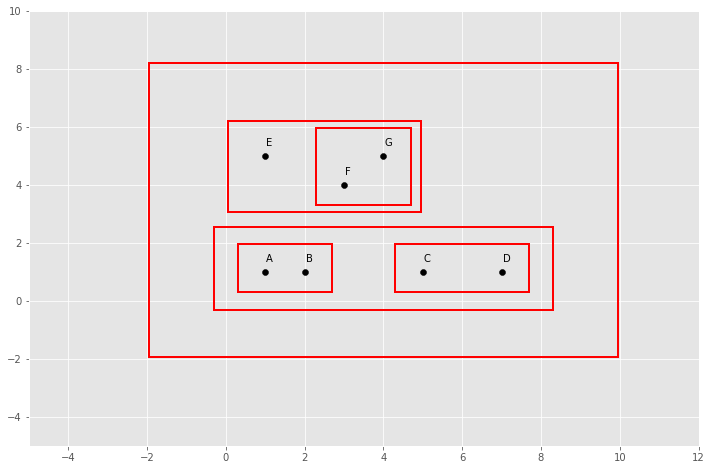

In [692]:
# Plot the Data and plot a box around each hierarchical cluster

fig, axs=plot_data(cl6, labels, xlim=(-5,12), ylim=(-5,10))
plot_cluster(axs,cl1)
plot_cluster(axs,cl2)
plot_cluster(axs,cl3)
plot_cluster(axs,cl4)
plot_cluster(axs,cl5)
plot_cluster(axs,cl6)

**PROBLEM**: Using the data you have calculated above, now plot a dendogram below. You may do this manually usinge the `images/A3-Fig-2.png` file and editing it in an image editing program (save your edits to that file, and commit changes to your repository). Or try to use special functions in matplot lib to plot it directly.

<img src="images/A3-Dendogram.png" width="800" height="800" align="center"/>

In [693]:
Z = hierarchy.linkage(data, 'single')

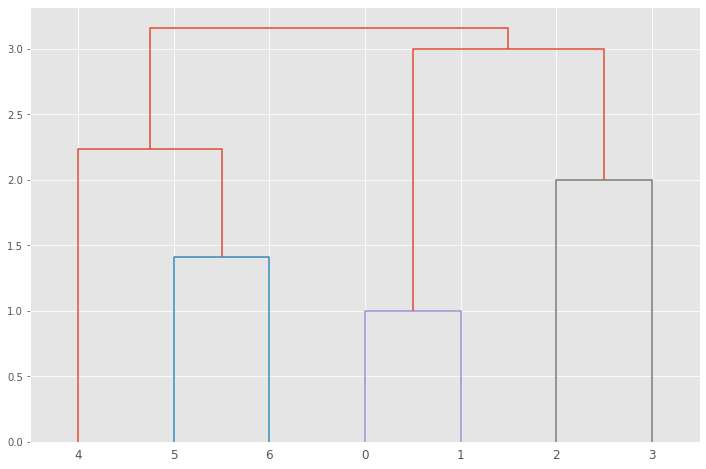

In [694]:
#ABCDEFG=0123456
#EFGABCD
dn = dendrogram(Z)
plt.show()

In [695]:
display(pd.DataFrame([['A,B',distance(data[0],data[1]),distortion(cl1),cl1],
['F,G',distance(data[5],data[6]),distortion(cl2),cl2],
['C,D',distance(data[2],data[3]),distortion(cl3),cl3],
['E,F,G',distance(data[4],data[5]),distortion(cl4),cl4],
['A,B,C,D',separation(cl1,cl3),distortion(cl5),cl5],
['A,B,C,D,E,F,G',separation(cl4,cl5),distortion(cl6),cl6]],columns=['CLUSTER','DISTANCE','DISTORTION','MEMBERS']))

CLUSTER  DISTANCE  DISTORTION  \
0  A,B            1.000000  0.500000     
1  F,G            1.414214  1.000000     
2  C,D            2.000000  2.000000     
3  E,F,G          2.236068  5.333333     
4  A,B,C,D        3.000000  22.750000    
5  A,B,C,D,E,F,G  3.162278  53.142857    

                                                    MEMBERS  
0  [(1, 1), (2, 1)]                                          
1  [(3, 4), (4, 5)]                                          
2  [(5, 1), (7, 1)]                                          
3  [(1, 5), (3, 4), (4, 5)]                                  
4  [(1, 1), (2, 1), (5, 1), (7, 1)]                          
5  [(1, 1), (2, 1), (5, 1), (7, 1), (1, 5), (3, 4), (4, 5)]

**PROBLEM**: Using your dendogram, report which observations would be grouped together if you had three clusters.

Cluster 1: __A,B__________ 

Cluster 2: ____C,D________ 

Cluster 3: ____E,F,G________

**PROBLEM**: Using your dendogram, report which observations would be grouped together if you had five clusters.

Cluster 1: ___E_________ 

Cluster 2: ______F,G______ 

Cluster 3: __A,B__________

Cluster 4: ____C________

Cluster 5: ____D________

# **PART 5**: Data Exploration

We now return to the Credit Card Default problem from Assignment 2 to try a new approach to data exploration. First, let's again reset the notebook magic command `%reset -f`

In [696]:
%reset -f

### **Load and Explore the Data**  

Manually digging through your data (sorting, filtering, and inspecting) is important, so we always want you to spend time to get to know your dataset. For this assignment, you will us ehte same data as before, but now you will use [Pandas GUI](https://github.com/adamerose/pandasgui) to explore it. Please see the online documentation. **pandasgui** uses a pop-open window and than may not work on a VM. If it does not, then try to accomplish the same results manually and show the dataframe directly in the notebook.
  
To show your work below, take a **screenshot** of each answer to the problem and then include it (in markdown) in your notebook. Save your screenshots into a `/screenshots/` subdirectory to keep everything oprganized, and then display the screenshots directly into this notebook to show that you have completed the problem. We will show you how to do that in an example below. Remember to `git add` and `git commit` the screenshots when you submit your assignment.

In [1]:
# Import the pandas and pandasgui package
import pandas as pd
import pandasgui as pg
from pandasgui import show

In [2]:
# Load Data
data = pd.read_csv('data/credit_data.csv')

**PROBLEM**: Use pandasgui to open and explore the dataset.

In [3]:
# Open and explore the dataset

show(data)


In [6]:
import matplotlib.image as mpimg
img=mpimg.imread('screenshots/Filter_for_married_female.png')

In [9]:
import matplotlib.pyplot as plt

In [12]:
img2=mpimg.imread('screenshots/Married female.png')

![](./screenshots/screenshot-01.png)

**PROBLEM**: Use the "filter" funtion of **pandasgui** to filter down to married women and show the results. (Show the screenshot)

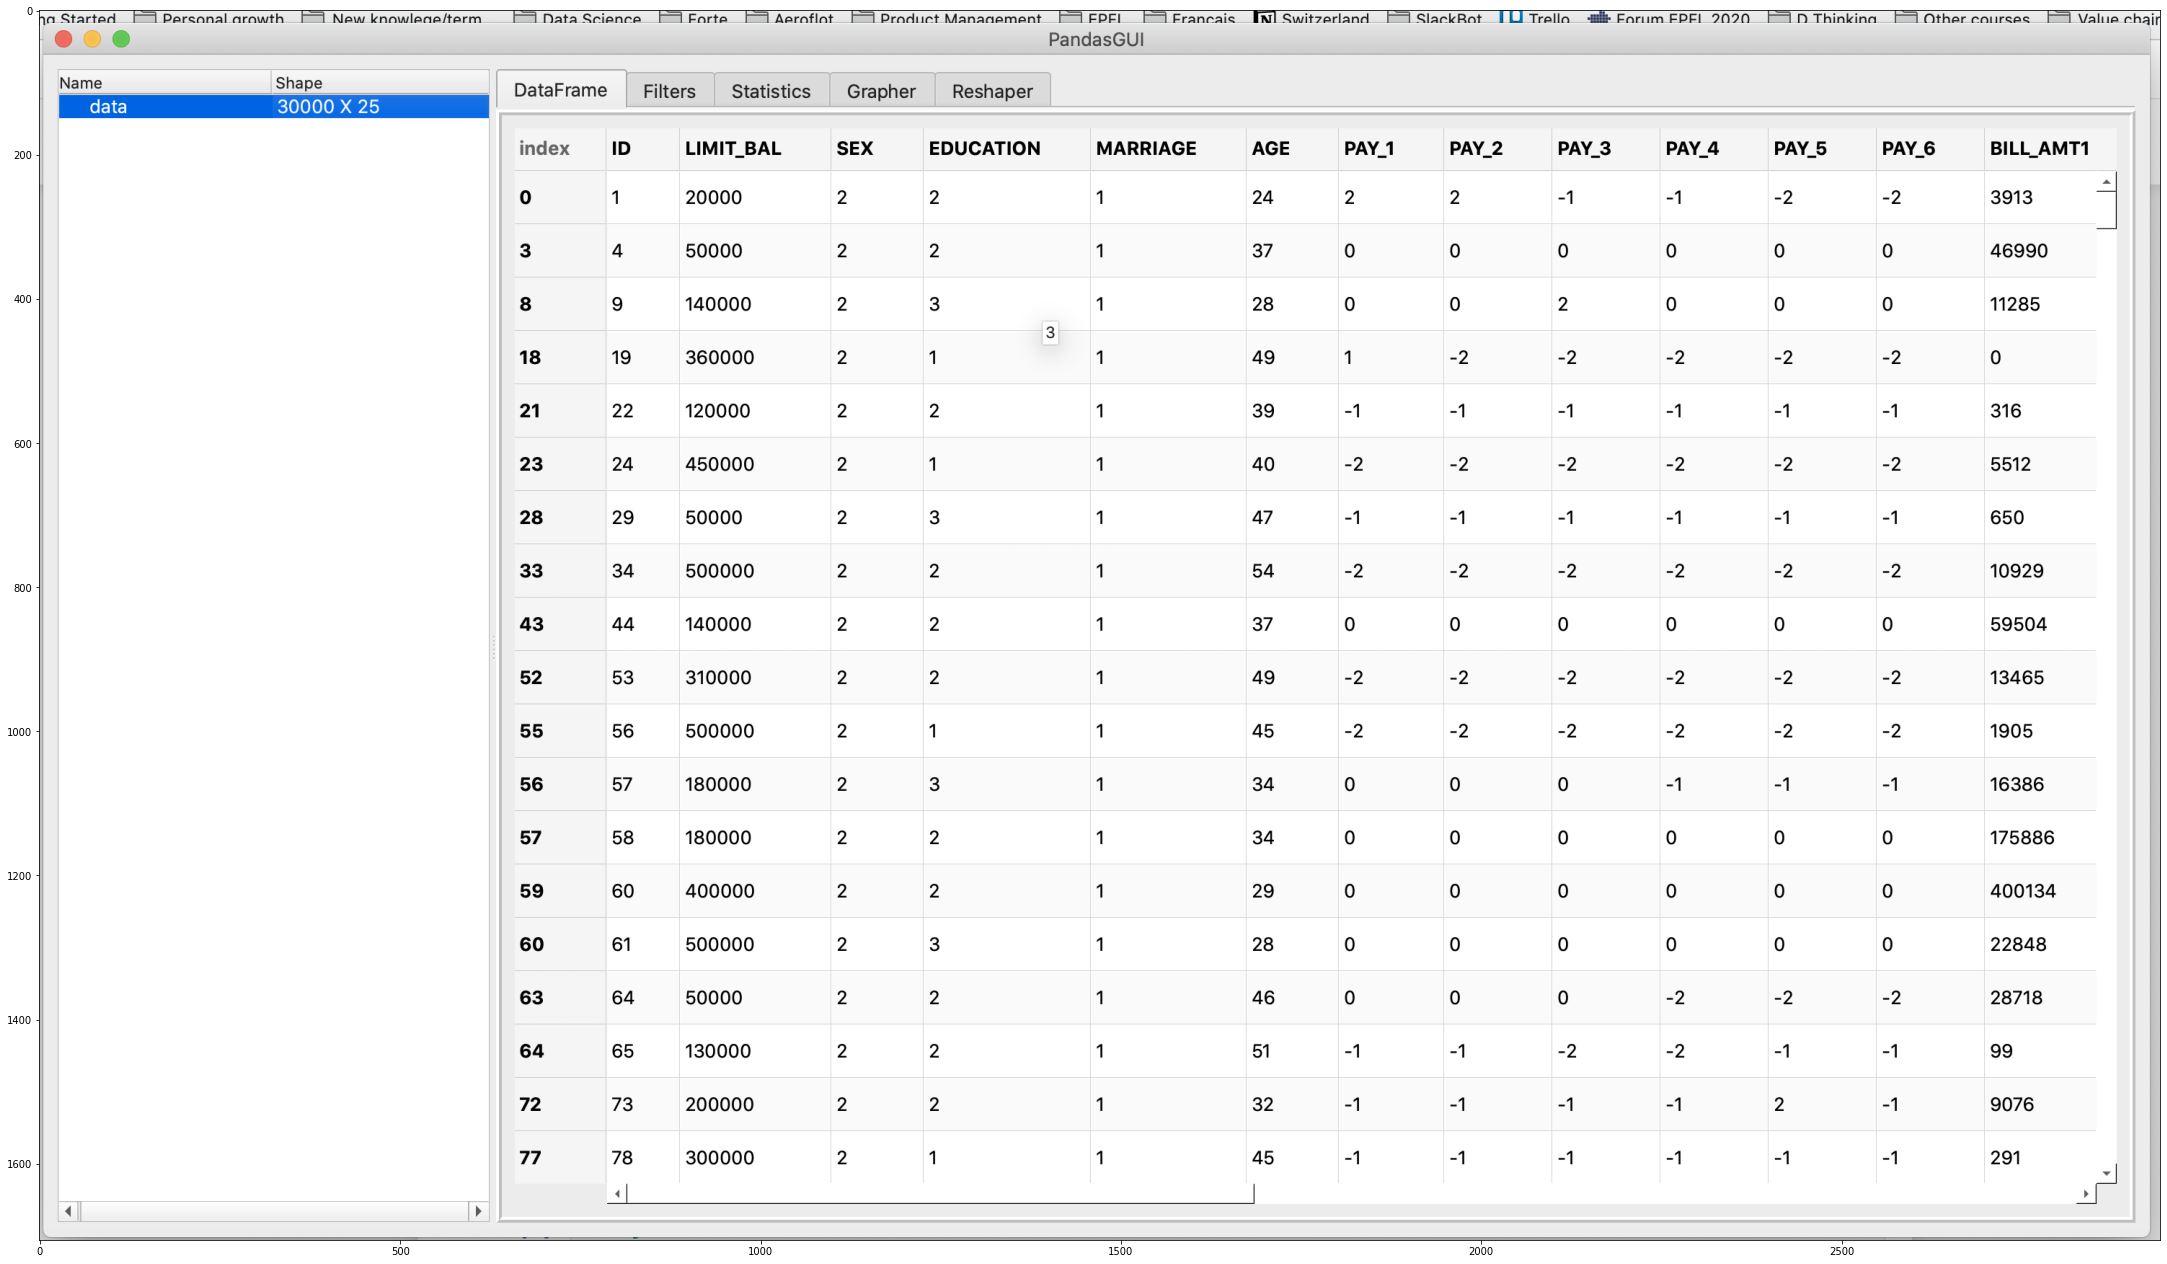

In [18]:
fig, ax = plt.subplots(figsize=(38, 30))
ax.imshow(img2)

![](./screenshots/screenshot-02.png)

**PROBLEM**: Show the filter you used to get those results. (Show the screenshot)

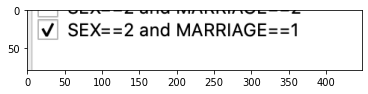

In [11]:
imgplot = plt.imshow(img)

![](./screenshots/screenshot-03.png)

# **PART 6**: PCA
As an interesting learning exercise, visualize ALL your data in 2 dimensions using PCA. PCA is only able to capture linear variations in the data. For non-linear projections, one could also use T-SNE. However, T-SNE has more tunable parameters compared to PCA.

| Feature name     | Variable Type | Description 
|------------------|---------------|--------------------------------------------------------
| customer_default | Binary        | 1 = default in following month; 0 = no default 
| LIMIT_BAL        | Continuous    | Credit limit   
| SEX              | Categorical   | 1 = male; 2 = female
| EDUCATION        | Categorical   | 1 = graduate school; 2 = university; 3 = high school; 4 = others
| MARRIAGE         | Categorical   | 0 = unknown; 1 = married; 2 = single; 3 = others
| AGE              | Continuous    | Age in years  
| PAY1             | Categorical   | Repayment status in September, 2005 
| PAY2             | Categorical   | Repayment status in August, 2005 
| PAY3             | Categorical   | Repayment status in July, 2005 
| PAY4             | Categorical   | Repayment status in June, 2005 
| PAY5             | Categorical   | Repayment status in May, 2005 
| PAY6             | Categorical   | Repayment status in April, 2005 
| BILL_AMT1        | Continuous    | Balance in September, 2005  
| BILL_AMT2        | Continuous    | Balance in August, 2005  
| BILL_AMT3        | Continuous    | Balance in July, 2005  
| BILL_AMT4        | Continuous    | Balance in June, 2005 
| BILL_AMT5        | Continuous    | Balance in May, 2005  
| BILL_AMT6        | Continuous    | Balance in April, 2005  
| PAY_AMT1         | Continuous    | Amount paid in September, 2005
| PAY_AMT2         | Continuous    | Amount paid in August, 2005
| PAY_AMT3         | Continuous    | Amount paid in July, 2005
| PAY_AMT4         | Continuous    | Amount paid in June, 2005
| PAY_AMT5         | Continuous    | Amount paid in May, 2005
| PAY_AMT6         | Continuous    | Amount paid in April, 2005

**PROBLEM**: Use the sklearn StandardScaler() to standardize all of your features.

In [83]:
# Standardize ALL features
from sklearn.preprocessing import StandardScaler
import numpy as np
scaler=StandardScaler()
"""data_continious=pd.concat([pd.concat([data.loc[:,'BILL_AMT1':'PAY_AMT6'],data.loc[:,'LIMIT_BAL']],axis=1),
                           data.loc[:,'AGE']],axis=1)
scaler.fit_transform(data_continious)"""
# Select target
y = np.array(data['customer_default'])

# Select features 
features = list(set(list(data.columns)) - set(['customer_default']))
X = data.loc[:, features]

X_scale_all=scaler.fit_transform(X)

**PROBLEM**: Use the sklearn PCA() function to project ALL features into just two dimensions.

In [85]:
import plotly.express as px
from sklearn.decomposition import PCA


pca = PCA(n_components=2)
components = pca.fit_transform(X_scale_all)

fig = px.scatter(components, x=0, y=1, color=y)
fig.show()

In [86]:
import plotly.express as px
from sklearn.decomposition import PCA


pca = PCA(n_components=2)
components = pca.fit_transform(X_scale_all)

fig = px.scatter(components, x=0, y=1, color=np.where(y==0,'default','no_default'))
fig.show()

**PROBLEM**: Explore the relationship between the AUC from a standard Logit Model (withOUT using Lasso) and the number of PCA Component Features being used as predictors in the model. In other words, build a `for` loop that tries many numbers of components from PCA in a basic Logit Model.  

Hint: you will need to use code like the following in order to build up a pipeline comprised of the StandardScaler(), PCA(), and LogisticRegression() steps.

    estimators = []
    estimators.append(('standardize', StandardScaler()))
    estimators.append(('pca', PCA()))
    estimators.append(('model', LogisticRegression()))
    pipeline = Pipeline(estimators)
    

In [87]:
# Explore and print out results for the relationship between AUC and the number of PCA Component Features
from sklearn.linear_model    import LogisticRegression

from sklearn.pipeline import Pipeline
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('pca', PCA()))
estimators.append(('model', LogisticRegression()))
pipeline = Pipeline(estimators)
i=50
pipeline.set_params(pca__n_components=i/100) 
pipeline.fit(X,y)

Pipeline(steps=[('standardize', StandardScaler()),
                ('pca', PCA(n_components=0.5)),
                ('model', LogisticRegression())])

**PROBLEM**: Plot your incremental results (increasing levels of components) from the steps above.

In [101]:
# Plot your incremental results (increasing levels of components) from the steps above.
from sklearn.metrics import roc_auc_score
r_a=[]
#X_train, X_test,y_train, y_test
for i in np.arange(90,100,0.5):
    pipeline.set_params(pca__n_components=i/100) 
    pipeline.fit(X,y)
    y_scores=pipeline.predict(X)
    r_a.append(roc_auc_score(y, y_scores))



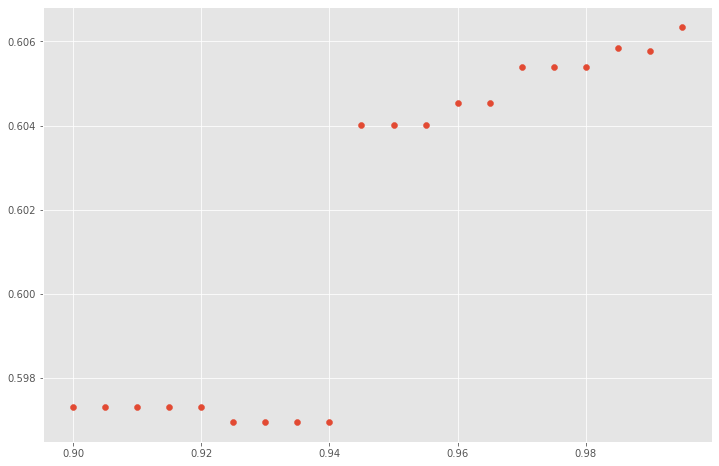

In [103]:
plt.scatter(np.arange(90,100,0.5)/100,r_a)

# **PART 7**:  K-Nearest Neighbors (KNN)

Again to help you get going, we will set up a basic pipeline for hyperparameter tuning K for you...

In [ ]:
# Build pipeline
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('knn_model', KNeighborsClassifier()))
pipeline = Pipeline(estimators) 

**PROBLEM**: Tune the KNN model to find the optimal K.

In [ ]:
# Tune K



    
# View results 





**PROBLEM**: What was the best K?

In [ ]:
# Select best K




**PROBLEM**: Test your final model and report the AUC.

In [ ]:
# Test final model 





In [ ]:
# Plot ROC
